[Dataset과 Dataloader](https://tutorials.pytorch.kr/beginner/basics/data_tutorial.html)

In [4]:
_ = """
데이터셋 코드를 모델 학습 코드로부터 분리하기
    1. 가독성
    2. 모듈성

PyTorch
    1. torch.utils.data.DataLoader
        Dataset을 순회 가능한 객체로 감싸서 샘플에 쉽게 접근할 수 있도록 함
    2. torch.utils.data.Dataset
        샘플과 정답 제공
"""

## 데이터셋 불러오기

In [5]:
"""
데이터셋 불러오기
    root: 학습/테스트 데이터가 저장되는 경로
    train: 학습용 또는 테스트용 데이터셋 여부 지정
    download=Ture: root에 데이터가 없는 경우 인터넷에서 다운로드
    transform/target_transform: 특징과 정답 변형을 지정
"""

import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:01<00:00, 16088008.95it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 273261.00it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4972517.68it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 18597999.13it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



## 데이터셋을 순회하고 시각화하기

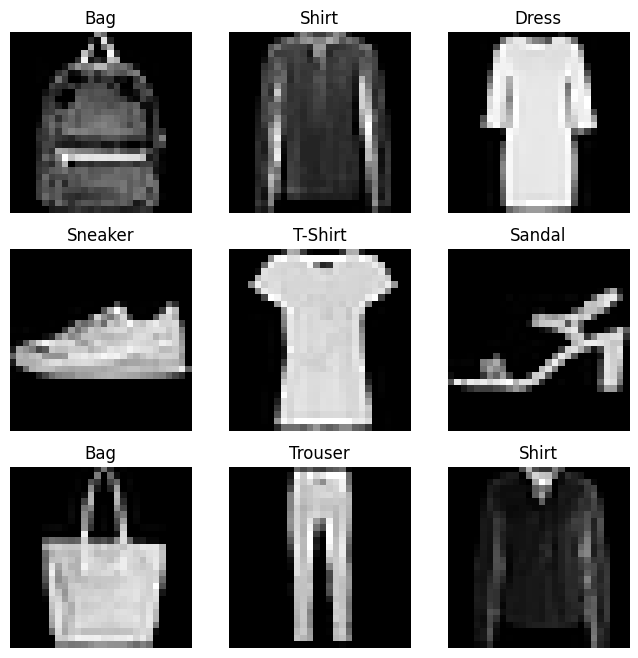

In [7]:
# Dataset에 리스트처럼 직접 접근
# 학습 데이터의 일부를 시각화하기
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")

    # squeeze: 차원이 1인 차원 제거, 차원을 설정시 해당 차원만 제거
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## 파일에서 사용자 정의 데이터셋 만들기

In [8]:
"""
사용자 정의 Dataset 클래스
    1. __init__
    2. __len__
    3. __getitem__
"""

# 이미지: img_dir에 저장
# 정답: annotations_file csv파일에 저장

import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(
        self,
        annotations_file,
        img_dir,
        transform=None,
        target_transform=None,
    ):
        # names 인자로 컬럼명 지정하기
        self.img_labels = pd.read_csv(annotations_file, names=['file_name', 'label'])
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

### \_\_init\_\_

Dataset 객체가 생성될 때 한 번만 실행\
이미지 및 주석 파일이 포함된 디렉토리와 두가지 변형을 초기화

* labels.csv 파일의 예시

```python
tshirt1.jpg, 0
tshirt2.jpg, 0
......
ankleboot999.jpg, 9
```

```python
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform
```

### \_\_len\_\_

데이터셋의 샘플 개수를 반환

```python
def __len__(self):
    return len(self.img_labels)
```

### \_\_getitem\_\_

주어진 인덱스 `idx`에 해당하는 샘플을 데이터셋에서 불러오고 반환

인덱스를 기반으로 디스크에서 이미지의 위치를 식별\
`read_image`를 사용해 이미지를 텐서로 변환\
`self.img_labels`의 csv 데이터로부터 해당하는 정답을 가져옴\
해당하는 경우 변형 함수들 호출\
텐서 이미지 및 라벨을 사전형으로 반환

```python
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    sample = {"image": image, "label" label}
    return sample
```

## DataLoader로 학습용 데이터 준비

In [9]:
"""
Dataset
    데이터셋의 특징 가져오고, 하나의 샘플에 정답을 지정하는 일을 수행
DataLoader(순회 가능한 객체)
    샘플들을 미니배치로 전달
    매 epoch마다 데이터를 다시 섞어서 과적합 방지
    multiprocessing 사용하여 검색 속도 높임
"""

from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    training_data,
    batch_size=64,
    shuffle=True,
)

test_dataloader = DataLoader(
    test_data,
    batch_size=64,
    shuffle=True
)

## DataLoader를 통해 순회(iterate)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


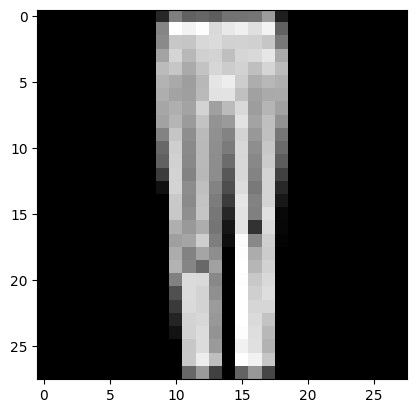

Label: 1


In [11]:
"""
DataLoader에 데이터셋을 불러온 뒤 데이터셋을 순회할 수 있다
아래의 순회는 train_features와 train_labels의 묶음(batch)을 반환한다
    각각 batch_size=64

shuffle=True이므로, 모든 배치를 순회한 뒤 데이터가 섞인다
"""

# 이미지와 정답 표시
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0].squeeze()
label = train_labels[0]

plt.imshow(img, cmap="gray")
plt.show()

print(f"Label: {label}")